In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv(r"C:\Users\bharath simha reddy\Downloads\ecommerce\data.csv",encoding='latin1')
print('Shape:',df.shape)
print("\nColums:",df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Shape: (541909, 8)

Colums: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
#Data quality Check
print("Missing values:")
print(df.isnull().sum())
print("\nNegative Quantities:")
print(df[df['Quantity']<0].shape[0])
print("\nNegative Price:")
print(df[df['UnitPrice']<0].shape[0])
print("\nUnique Countries:")
print(df['Country'].nunique())
print("\nDateRange:")
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
print("From:",df['InvoiceDate'].min())
print("To:",df['InvoiceDate'].max())

Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Negative Quantities:
10624

Negative Price:
2

Unique Countries:
38

DateRange:
From: 2010-12-01 08:26:00
To: 2011-12-09 12:50:00


In [12]:
#Clean data
df_clean=df.dropna(subset=['CustomerID','Description'])
df_clean=df_clean[df_clean['Quantity']>0]
df_clean=df_clean[df_clean['UnitPrice']>0]
df_clean['Revenue']=df_clean['Quantity']*df_clean['UnitPrice']
print("Original shape:",df.shape)
print("Clean shape:",df_clean.shape)
print("Rows Removed:",df.shape[0]-df_clean.shape[0])

Original shape: (541909, 8)
Clean shape: (397884, 9)
Rows Removed: 144025


In [14]:
# Save clean data
df_clean.to_csv(r"C:\Users\bharath simha reddy\Downloads\uk_ecommerce_clean.csv", index=False)
print("Clean data saved successfully!")
print("Shape:", df_clean.shape)

Clean data saved successfully!
Shape: (397884, 9)


In [15]:
import sqlite3
conn=sqlite3.connect('ecommerce.db')
df_clean.to_sql('ecommerce',conn,if_exists='replace',index=False)
print('Database created successfuly')
print("Table 'ecommerce' loaded with",len(df_clean),"rows")

Database created successfuly
Table 'ecommerce' loaded with 397884 rows


In [18]:
#Revenue by country
query1="""
select Country,
round(sum(Revenue),2) as Total_Revenue,
count(Distinct InvoiceNo) as Total_Orders
from ecommerce 
group by Country 
order by Total_Revenue desc limit 10
"""
result1=pd.read_sql_query(query1,conn)
print(result1)

          Country  Total_Revenue  Total_Orders
0  United Kingdom     7308391.55         16646
1     Netherlands      285446.34            94
2            EIRE      265545.90           260
3         Germany      228867.14           457
4          France      209024.05           389
5       Australia      138521.31            57
6           Spain       61577.11            90
7     Switzerland       56443.95            51
8         Belgium       41196.34            98
9          Sweden       38378.33            36


In [20]:
#top 10 best selling products
query2="""
select Description,sum(Quantity) as Total_Quantity,round(sum(Revenue),2) as Total_Revenue
from ecommerce
group by Description
order by Total_Quantity desc 
limit 10
"""
rslt2=pd.read_sql_query(query2,conn)
print(rslt2)

                          Description  Total_Quantity  Total_Revenue
0         PAPER CRAFT , LITTLE BIRDIE           80995      168469.60
1      MEDIUM CERAMIC TOP STORAGE JAR           77916       81416.73
2   WORLD WAR 2 GLIDERS ASSTD DESIGNS           54415       13586.25
3             JUMBO BAG RED RETROSPOT           46181       85220.78
4  WHITE HANGING HEART T-LIGHT HOLDER           36725      100448.15
5       ASSORTED COLOUR BIRD ORNAMENT           35362       56580.34
6     PACK OF 72 RETROSPOT CAKE CASES           33693       16394.53
7                      POPCORN HOLDER           30931       23427.71
8                  RABBIT NIGHT LIGHT           27202       51346.20
9             MINI PAINT SET VINTAGE            26076       16039.24


      Month  Monthly_Revenue  Total_Orders
0   2010-12        572713.89          1400
1   2011-01        569445.04           987
2   2011-02        447137.35           997
3   2011-03        595500.76          1321
4   2011-04        469200.36          1149
5   2011-05        678594.56          1555
6   2011-06        661213.69          1393
7   2011-07        600091.01          1331
8   2011-08        645343.90          1280
9   2011-09        952838.38          1755
10  2011-10       1039318.79          1929
11  2011-11       1161817.38          2657
12  2011-12        518192.79           778


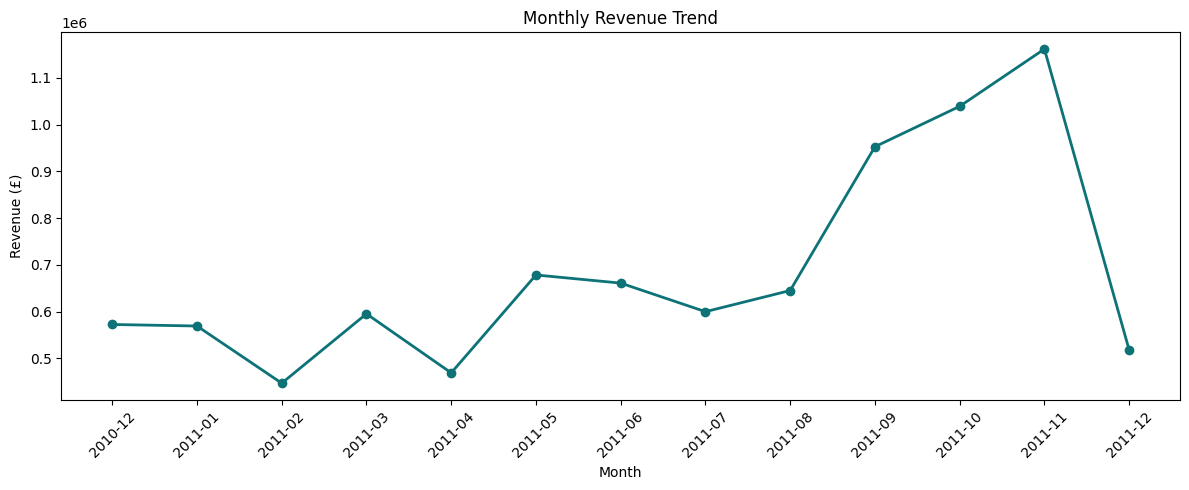

In [24]:
#monthly revenue trend
query3="""
select substr(InvoiceDate,1,7) as Month,round(sum(Revenue),2) as Monthly_Revenue,
count(Distinct InvoiceNo) as Total_Orders
from ecommerce 
group by Month
order by Month asc
"""
rslt3=pd.read_sql_query(query3,conn)
print(rslt3)

plt.figure(figsize=(12,5))
plt.plot(rslt3['Month'], rslt3['Monthly_Revenue'], 
         color='#0D7377', linewidth=2, marker='o')
plt.title('Monthly Revenue Trend')
plt.ylabel('Revenue (£)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Top 10 Customers by Revenue
query4 = """
SELECT CustomerID,
       ROUND(SUM(Revenue), 2) as Total_Revenue,
       COUNT(DISTINCT InvoiceNo) as Total_Orders,
       ROUND(AVG(Revenue), 2) as Avg_Order_Value
FROM ecommerce
GROUP BY CustomerID
ORDER BY Total_Revenue DESC
LIMIT 10
"""

result4 = pd.read_sql_query(query4, conn)
print(result4)

   CustomerID  Total_Revenue  Total_Orders  Avg_Order_Value
0     14646.0      280206.02            73           134.97
1     18102.0      259657.30            60           602.45
2     17450.0      194550.79            46           577.30
3     16446.0      168472.50             2         56157.50
4     14911.0      143825.06           201            25.34
5     12415.0      124914.53            21           174.95
6     14156.0      117379.63            55            83.84
7     17511.0       91062.38            31            94.56
8     16029.0       81024.84            63           334.81
9     12346.0       77183.60             1         77183.60


In [26]:
# Average Order Value by Country
query5 = """
SELECT Country,
       ROUND(AVG(Revenue), 2) as Avg_Order_Value,
       COUNT(DISTINCT CustomerID) as Total_Customers
FROM ecommerce
GROUP BY Country
ORDER BY Avg_Order_Value DESC
LIMIT 10
"""

result5 = pd.read_sql_query(query5, conn)
print(result5)


       Country  Avg_Order_Value  Total_Customers
0  Netherlands           121.00                9
1    Australia           117.19                9
2        Japan           116.56                8
3    Singapore            95.85                1
4       Sweden            85.10                8
5      Denmark            49.88                9
6    Lithuania            47.46                1
7      Lebanon            37.64                1
8         EIRE            36.70                3
9       Brazil            35.74                1


In [27]:
# Save all SQL results for Power BI
result1.to_csv(r"C:\Users\bharath simha reddy\Downloads\revenue_by_country.csv", index=False)
rslt2.to_csv(r"C:\Users\bharath simha reddy\Downloads\top_products.csv", index=False)
rslt3.to_csv(r"C:\Users\bharath simha reddy\Downloads\monthly_trend.csv", index=False)
result4.to_csv(r"C:\Users\bharath simha reddy\Downloads\top_customers.csv", index=False)
result5.to_csv(r"C:\Users\bharath simha reddy\Downloads\avg_order_country.csv", index=False)

print("All files saved successfully!")

All files saved successfully!
